In [2]:
from netCDF4 import Dataset
import numpy as np
import os
import datetime
import pickle
import xarray as xr
from regrid import regrid
import matplotlib.pyplot as plt
import tqdm

In [3]:
SM = Dataset('SM/snod_ext.nc')

In [4]:
mask = Dataset('mask.nc')
mask

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    origin: Mask from Changes in Arctic melt season and implications for sea ice loss, J. C. Stroeve  T. Markus  L. Boisvert  J. Miller and A. Barrett
    regions: {'Lakes': 0, 'Oceans': 1, 'Okhotsk': 2, 'Bering': 3, 'Hudson': 4, 'St Lawrence': 5, 'Baffin': 6, 'Greenland': 7, 'Barents': 8, 'Kara': 9, 'Laptev': 10, 'East Siberian': 11, 'Chukchi': 12, 'Beaufort': 13, 'Canadian Archipelago': 14, 'Central Arctic': 15, 'Land': 20, 'Coast': 21}
    dimensions(sizes): x(361), y(361)
    variables(dimensions): float64 mask_values(x,y), float32 lon(x,y), float32 lat(x,y)
    groups: 

In [5]:
WG_data = {}

WG_dir = '/home/robbie/Dropbox/SM_Interp/WG'

files = os.listdir(WG_dir)

for f in tqdm.tqdm(files):
    
    d_str = f.split('_')[1]

    dt = datetime.datetime.strptime(d_str, '%Y%m%d').date()

    d = Dataset(WG_dir+'/'+f)


    rf = regrid(np.array(d['radar_freeboard']),
                np.array(d['lon']),
                np.array(d['lat']),
                np.array(mask['lon']),
                np.array(mask['lat']),
                method='nearest')

    WG_data[dt] = rf

  0%|          | 0/145 [00:00<?, ?it/s]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/robbie/anaconda3/lib/python3.7/site

In [6]:
SM_data = {}

dt0 = datetime.date(2018,8,31)

for date in sorted(WG_data):
    
    delta_t = (date - dt0).days
    
    snow_depth = np.array(SM['snod'][delta_t])
    
    snow_depth[snow_depth<0] = np.nan
    
    SM_data[date] = snow_depth

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [7]:
IT_data = {}

for date in tqdm.tqdm(sorted(WG_data)):
    
    y = date.year; m = date.month; d = date.day
    
    it = Dataset(f'ice_type/{y}/{str(m).zfill(2)}/ice_type_nh_ease2-250_icdr-v1p0_{y}{str(m).zfill(2)}{str(d).zfill(2)}1200.nc')
    
    IT_data[date] = regrid(it['ice_type'], it['lon'], it['lat'], mask['lon'], mask['lat'])

100%|██████████| 145/145 [00:21<00:00,  6.67it/s]


In [13]:
for year in [2019]:
    
    WG_lst, SM_lst, IT_lst, dt_lst, dates = [], [], [], [], []
    
    summer_d0 =  datetime.date(year,7,1)

    for date in tqdm.tqdm(sorted(WG_data)):

        if (date < summer_d0) and (date > (summer_d0 - datetime.timedelta(days=365))):

            WG_lst.append(WG_data[date])
            SM_lst.append(SM_data[date])
            IT_lst.append(IT_data[date])
            dt_lst.append((date-datetime.date(1970,1,1)).days)
            dates.append(date)

    WG_arr = np.array(WG_lst)
    SM_arr = np.array(SM_lst)
    IT_arr = np.array(IT_lst)

    #######

    data_vars = {'WG':(['t','x','y'],WG_arr),
                'SM':(['t','x','y'],SM_arr),
                'IT':(['t','x','y'],IT_arr),
                'mask':(['x','y'],np.array(mask['mask_values']))
                }

    ds = xr.Dataset(data_vars = data_vars,

                    coords={ 'lon':(['x','y'],mask['lon']),
                             'lat':(['x','y'],mask['lat']),
                             'dt' :(['t'],dt_lst)}    )

    ds.attrs["time"] = 'days since Jan 1st 1970'

    ds.to_netcdf(f'WG_SM_{year}.nc','w')

100%|██████████| 145/145 [00:00<00:00, 572668.63it/s]
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [9]:
np.diff(WG_arr,axis=0).shape

(144, 361, 361)

In [10]:
d = Dataset('WG_SM_2019.nc')
d

FYI_SM_mean = []
FYI_WG_mean = []


for i in range(len(d['dt'])):
    
    SM = np.array(d['SM'][i])/100
    WG = np.array(d['WG'][i])
    IT = np.array(d['IT'][i])
    
    FYI_SM = SM[IT==1]
    FYI_WG = WG[IT==1]
    
#     plt.imshow(WG)
#     plt.colorbar()
#     plt.show()
    
    
    FYI_SM_mean.append(np.nanmean(FYI_SM))
    FYI_WG_mean.append(np.nanmean(FYI_WG))

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_pat

<Figure size 640x480 with 0 Axes>

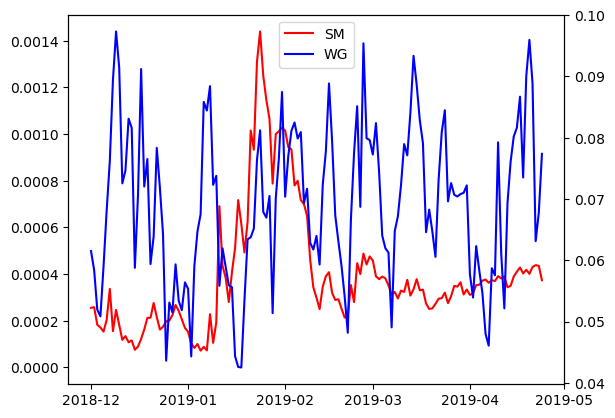

In [220]:
plt.figure()

fig, ax = plt.subplots(1,1)

ax.plot(dates,FYI_SM_mean,label='SM',color='r')
ax.plot([dates[0]],[0],color='b',label='WG')

ax2 = ax.twinx()

ax2.plot(dates,FYI_WG_mean,label='WG',color='b')

ax.legend(loc='upper center')

plt.show()

<Figure size 640x480 with 0 Axes>

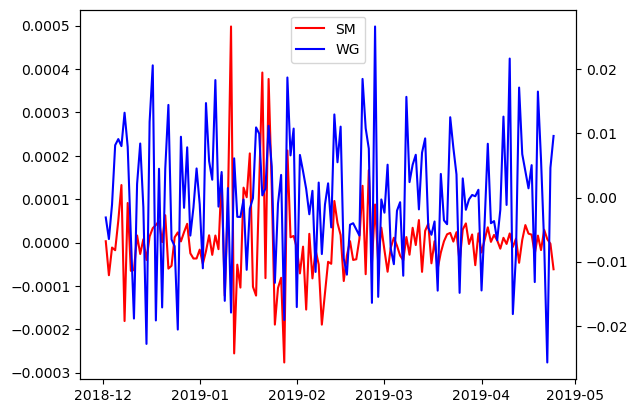

In [221]:
plt.figure()

fig, ax = plt.subplots(1,1)

ax.plot(dates[1:],np.diff(FYI_SM_mean-np.mean(FYI_SM_mean)),label='SM',color='r')
ax.plot([dates[0]],[0],color='b',label='WG')

ax2 = ax.twinx()

ax2.plot(dates[1:],np.diff(FYI_WG_mean-np.mean(FYI_WG_mean)),label='WG',color='b')

ax.legend(loc='upper center')

plt.show()

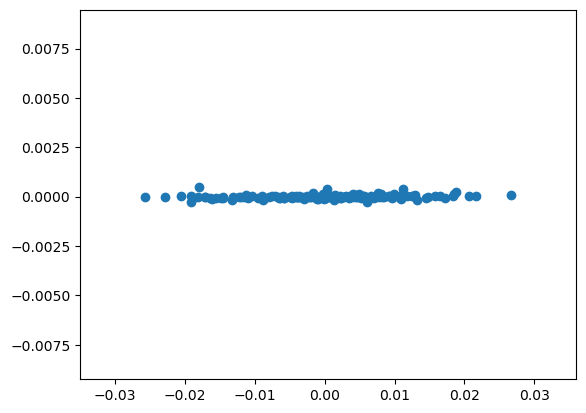

In [222]:
from scipy.stats import pearsonr

pearsonr(np.diff(FYI_WG_mean-np.mean(FYI_WG_mean)), np.diff(FYI_SM_mean-np.mean(FYI_SM_mean)))

plt.figure()

plt.scatter(np.diff(FYI_WG_mean-np.mean(FYI_WG_mean)), np.diff(FYI_SM_mean-np.mean(FYI_SM_mean)))

plt.show()

# plt.scatter()